# Human colonic mesenchyme HC & UC

paper: https://doi.org/10.1016/j.stem.2021.10.004 
dataset from: https://doi.org/10.1016/j.cell.2018.08.067

Kinchen et al. (2018) human HC & UC datasets integrated & batch corrected using scanorama, cell type labelled manually, glia subclustered, DEGs saved as csv file

In [1]:
import scanorama
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

In [2]:
magma = plt.cm.get_cmap('magma', 256)
magma_colors = magma(np.linspace(0, 1, 256))
grey = np.array([[0.8, 0.8, 0.8, 1.0]])
new_colors = np.vstack((grey, magma_colors[20:])) 
custom_cmap1 = ListedColormap(new_colors)

In [3]:
adata1 = sc.read_csv(r'C:\Users\dowpa\OneDrive\Desktop\NIM Lab\scRNA-seq\Project\Kinchen\GSE114374_Human_HC_expression_matrix.txt', delimiter='\t').T
adata2 = sc.read_csv(r'C:\Users\dowpa\OneDrive\Desktop\NIM Lab\scRNA-seq\Project\Kinchen\GSE114374_Human_UC_expression_matrix.txt', delimiter='\t').T

In [4]:
adata = sc.concat([adata1, adata2], label='condition', keys=['HC', 'UC'])

In [5]:
adata.obs['sample_id'] = adata.obs.index.str.split('-').str[1]

you would normally do preliminary filtering, normalisation and log-transform here, but i'm skipping it bc the data comes log-transformed

In [ ]:
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)

In [6]:
batch_key = 'sample_id'

In [7]:
adatas = [adata[adata.obs[batch_key] == batch_value].copy() for batch_value in adata.obs[batch_key].unique()]

In [8]:
scanorama.integrate_scanpy(adatas, dimred = 100)

Found 33694 genes among all datasets
[[0.         0.87180823 0.2260372  0.13460756]
 [0.         0.         0.53569567 0.35591454]
 [0.         0.         0.         0.8431092 ]
 [0.         0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (2, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (0, 2)
Processing datasets (0, 3)


In [9]:
adata_sc = adata.copy()
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]
all_s = np.concatenate(scanorama_int)
adata_sc.obsm['Scanorama'] = all_s

In [10]:
sc.pp.neighbors(adata_sc, use_rep='Scanorama')
sc.tl.umap(adata_sc)

In [11]:
sc.tl.leiden(adata_sc, resolution = 0.6)

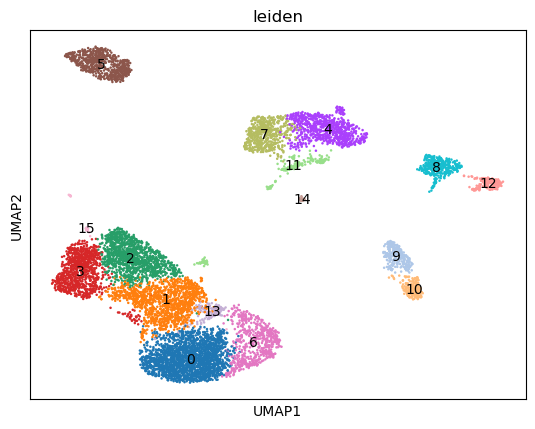

In [47]:
sc.pl.umap(adata_sc, color=['leiden'], legend_loc='on data', legend_fontweight='normal')

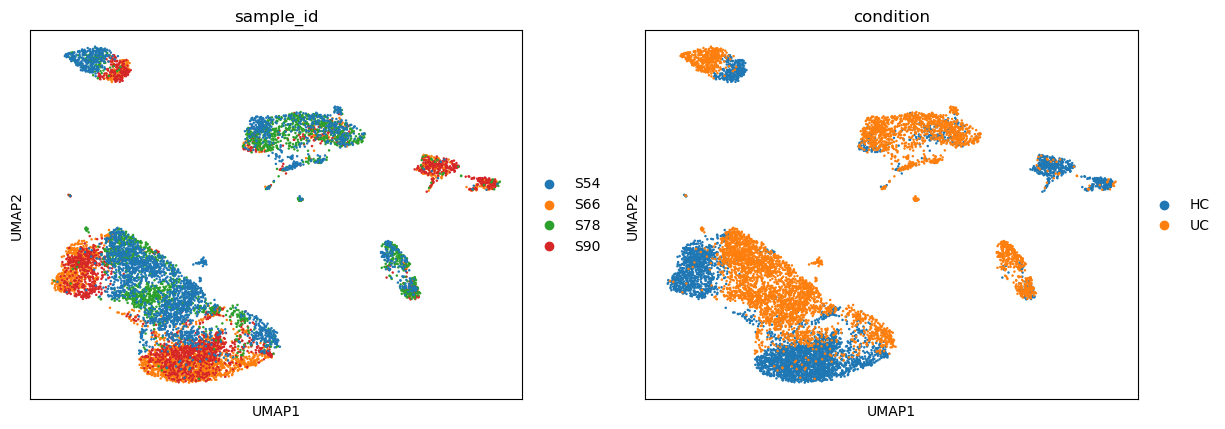

In [51]:
sc.pl.umap(adata_sc, color=[batch_key, 'condition'])

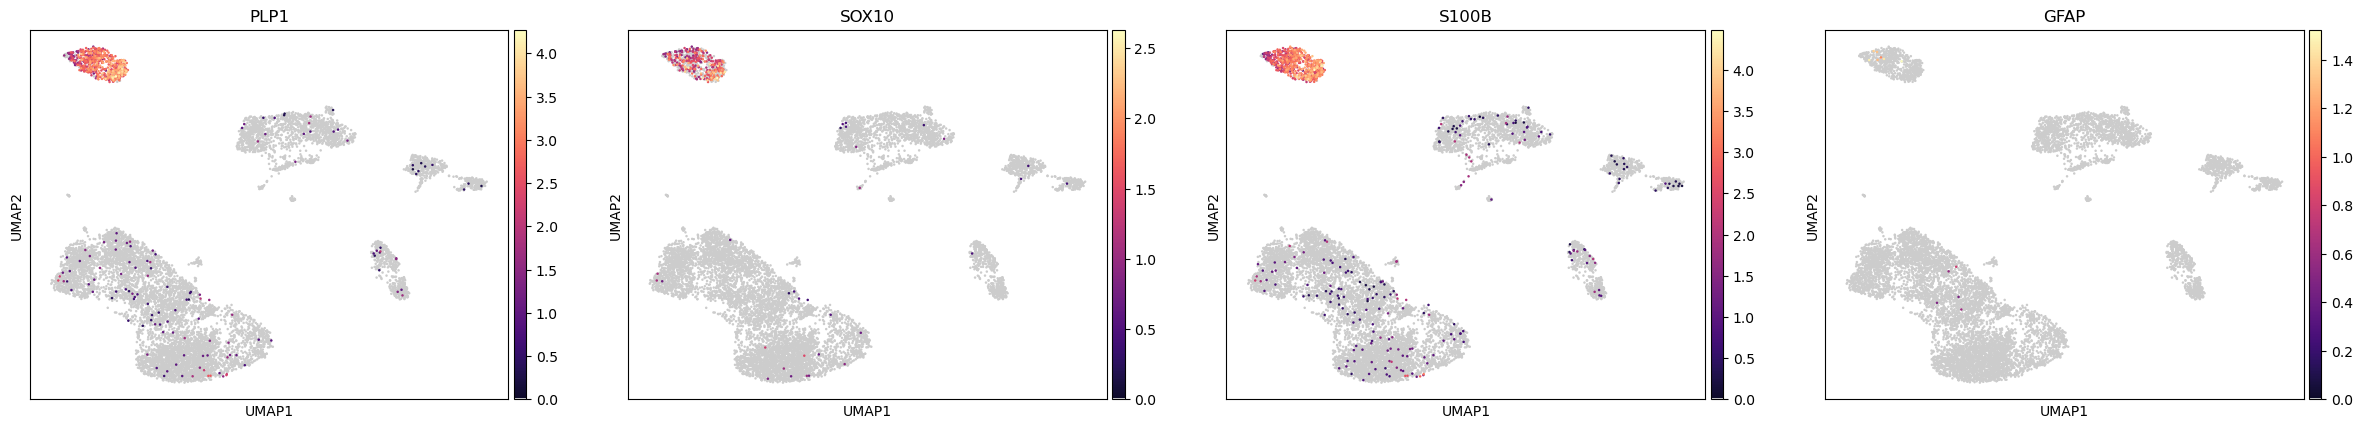

In [39]:
sc.pl.umap(adata_sc, color=['PLP1', 'SOX10', 'S100B', 'GFAP'], cmap=custom_cmap1)

marker genes were identified from Kichen et al.(2018)

In [53]:
colon_marker_genes = {
    'endothelial': ['PECAM1'],
    'glial': ['SOX10', 'PLP1', 'S100B'],
    'pericytes': ['RGS5'],
    'plasma cells': ['SDC1'],
    'stromal 1': ['APOE', 'CCL8', 'FABP5', 'ADAMDEC1'],
    'stromal 2': ['SOX6', 'VSTM2A', 'ID1', 'POSTN'],
    'stromal 3': ['KLF4', 'ID2', 'GREM1', 'OGN'],
    'stromal 4': ['ICAM1', 'IRF8', 'TNFSF13B', 'CCL19', 'IL32', 'C3'],
    'myofibroflasts': ['TAGLN', 'ACTA2', 'FLNA', 'TCEAL1'],
    'pan-fibroflast marker genes': ['VIM', 'COL1A2', 'COL3A1'],
    'IL11 related': ['IL11', 'IL11RA', 'IL6ST']
}

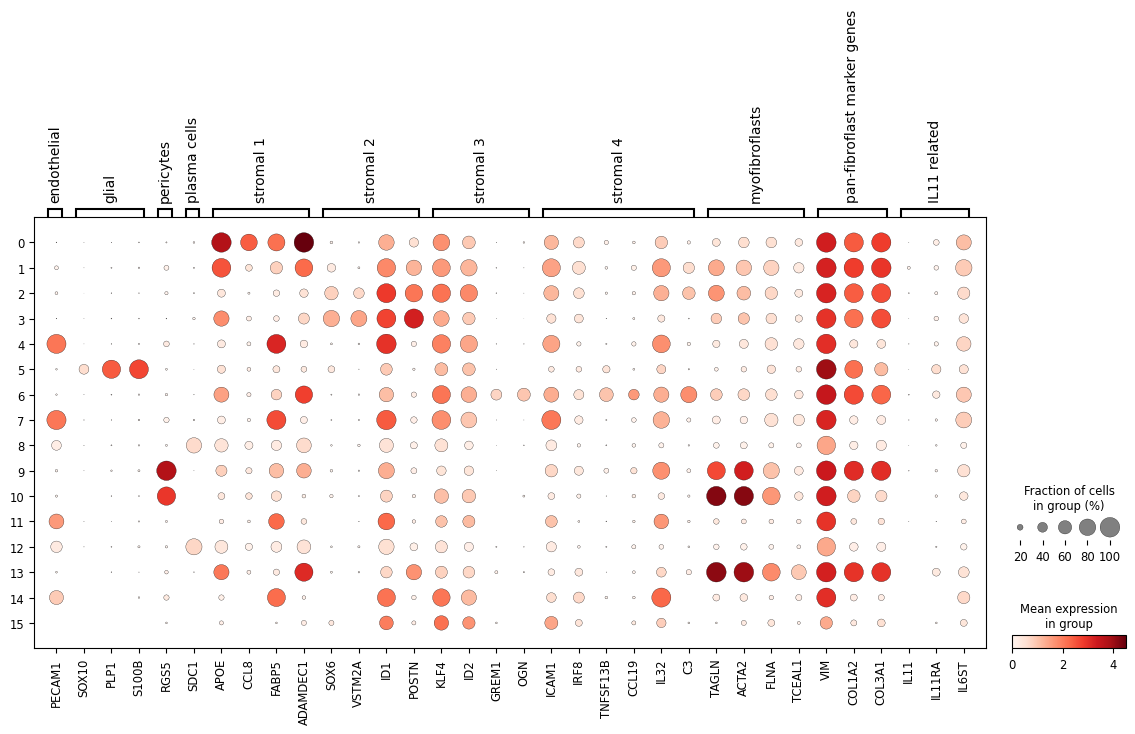

In [54]:
sc.pl.dotplot(adata_sc, colon_marker_genes, 'leiden')

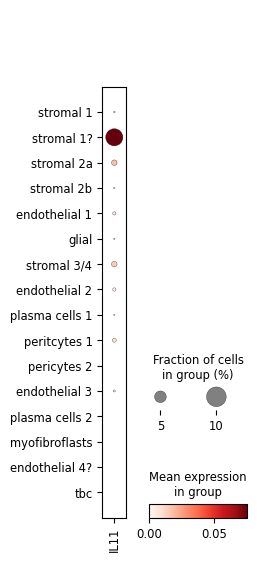

In [66]:
sc.pl.dotplot(adata_sc, ['IL11'], 'celltype')

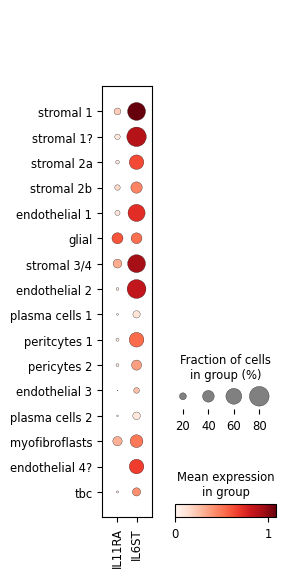

In [64]:
sc.pl.dotplot(adata_sc, ['IL11RA', 'IL6ST'], 'celltype') 

In [48]:
leiden_to_celltype = {
    '0': 'stromal 1',
    '1': 'stromal 1?',
    '2': 'stromal 2a',
    '3': 'stromal 2b',
    '4': 'endothelial 1',
    '5': 'glial',
    '6': 'stromal 3/4',
    '7': 'endothelial 2',
    '8': 'plasma cells 1',
    '9': 'peritcytes 1',
    '10': 'pericytes 2',
    '11': 'endothelial 3',
    '12': 'plasma cells 2',
    '13': 'myofibroflasts',
    '14': 'endothelial 4?',
    '15': 'tbc'
}

In [49]:
adata_sc.obs['celltype'] = adata_sc.obs['leiden'].map(leiden_to_celltype)

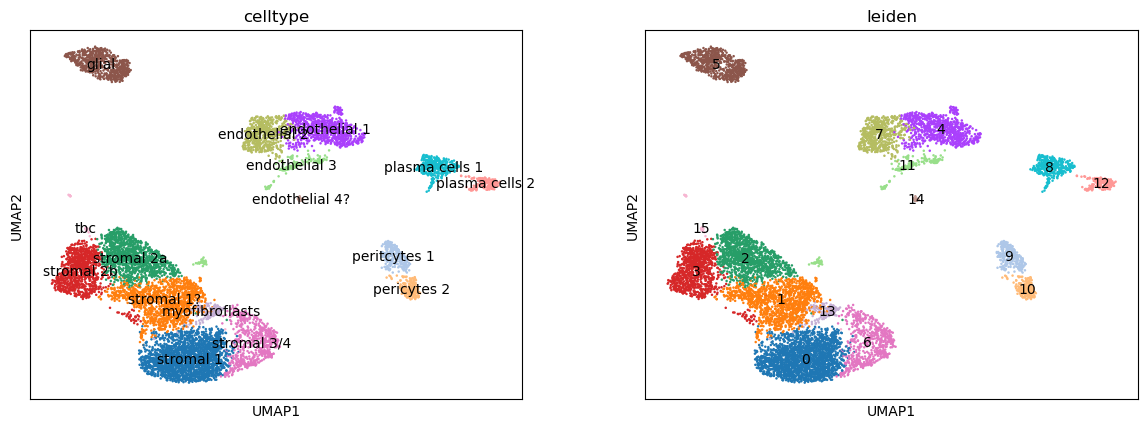

In [52]:
sc.pl.umap(adata_sc, color=['celltype', 'leiden'], legend_loc='on data', legend_fontweight='normal')

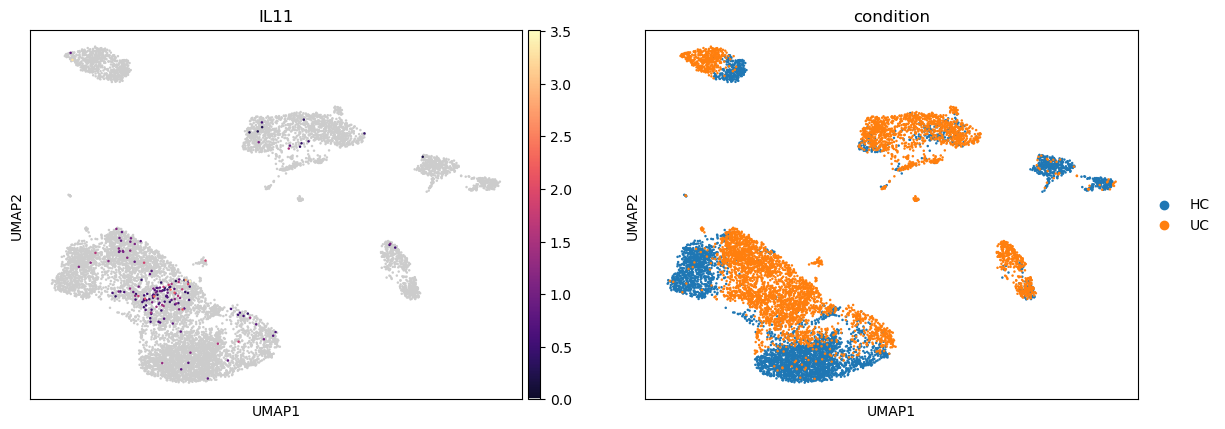

In [58]:
sc.pl.umap(adata_sc, color=['IL11', 'condition'], cmap=custom_cmap1)

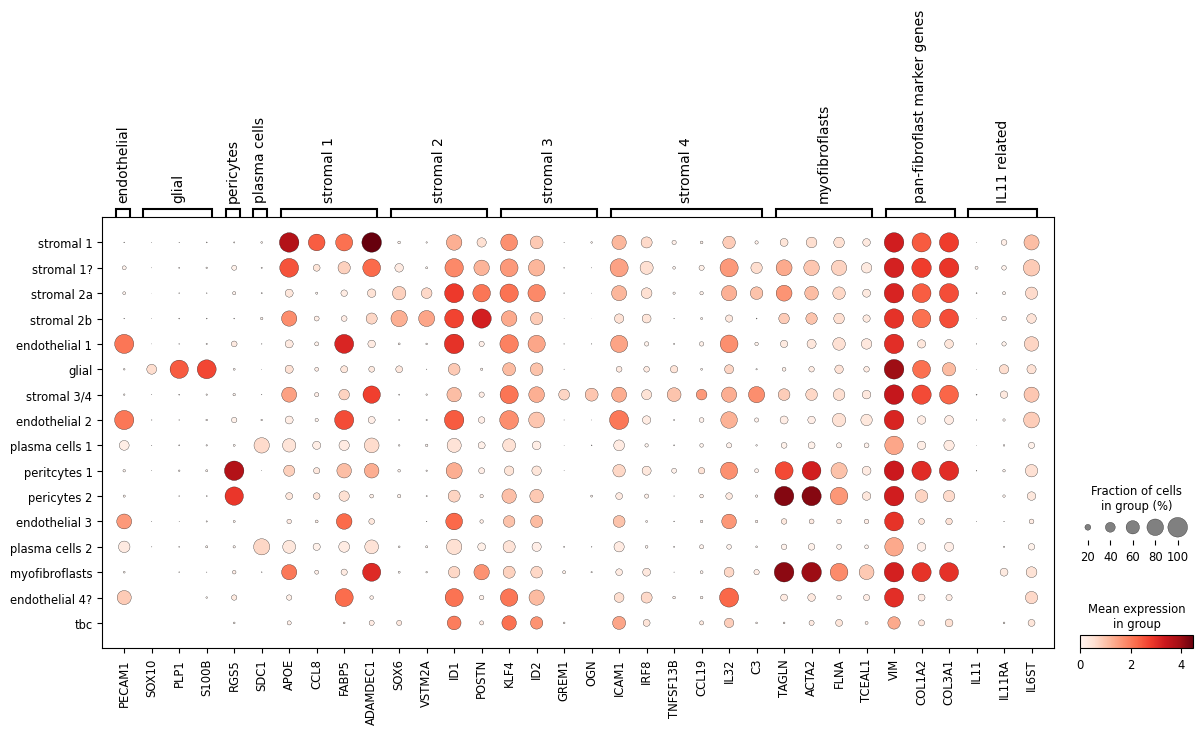

In [56]:
sc.pl.dotplot(adata_sc, colon_marker_genes, 'celltype')

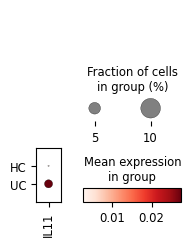

In [65]:
sc.pl.dotplot(adata_sc, 'IL11', 'condition')

## GLIAL CELL SUBCLUSTERING

In [27]:
gbarcodes = adata_sc[adata_sc.obs['leiden'] == '5'].obs_names

In [28]:
gadata = adata[adata.obs_names.isin(gbarcodes)].copy()

In [29]:
sc.pp.highly_variable_genes(gadata, flavor='seurat_v3', n_top_genes=2000)
gadata.raw = gadata.copy()
gadata = gadata[:, gadata.var.highly_variable].copy()

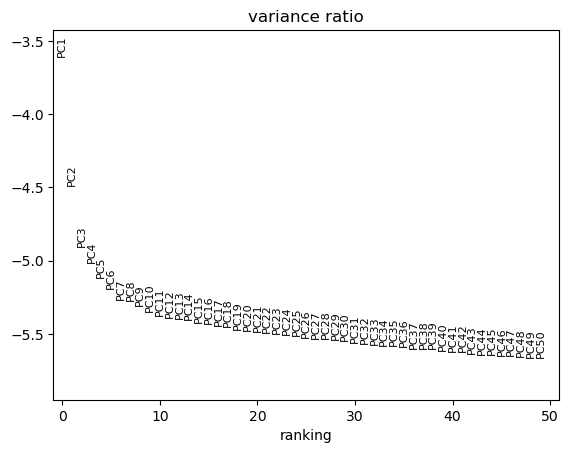

In [30]:
sc.pp.scale(gadata, max_value=10)
sc.tl.pca(gadata, svd_solver='arpack')
sc.pl.pca_variance_ratio(gadata, log=True, n_pcs = 50)

In [31]:
sc.pp.neighbors(gadata, n_neighbors = 10, n_pcs = 15)
sc.tl.umap(gadata)

  File "C:\Users\dowpa\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\dowpa\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dowpa\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\dowpa\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [32]:
sc.tl.leiden(gadata, resolution = 0.4)

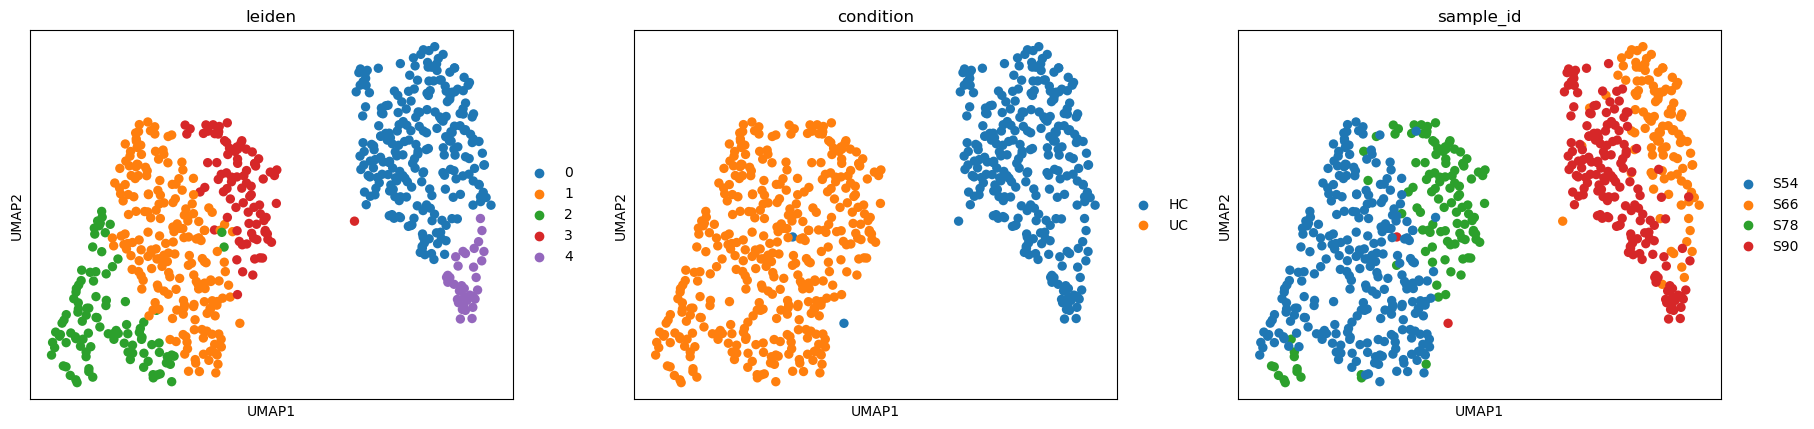

In [33]:
sc.pl.umap(gadata, color=['leiden', 'condition', 'sample_id'])

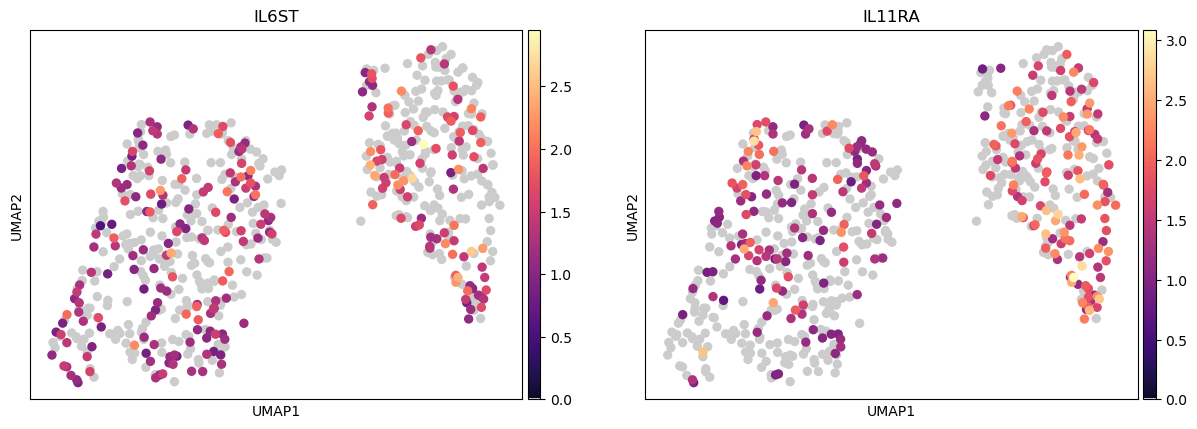

In [34]:
sc.pl.umap(gadata, color=['IL6ST', 'IL11RA'], cmap=custom_cmap1)

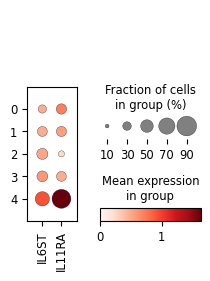

In [55]:
sc.pl.dotplot(gadata, ['IL6ST', 'IL11RA'], 'leiden', vmin=0)

In [35]:
sc.tl.rank_genes_groups(gadata, groupby='leiden', method='wilcoxon')

In [37]:
deg_df = sc.get.rank_genes_groups_df(gadata, group=None)

In [38]:
deg_df.to_csv('glia_leiden_cluster_deg.csv')

separate csv's per cluster - aviv & glia subcluster 
cellchat & cellphonedb learn 
stromal cell subclustering

## STROMAL CELL SUBCLUSTERING

In [69]:
sbarcodes = adata_sc[adata_sc.obs['leiden'].isin(['0', '1', '2', '3', '6', '13', '15'])].obs_names

In [79]:
sadata = adata[adata.obs_names.isin(sbarcodes)].copy()

In [81]:
sadatas = [sadata[sadata.obs[batch_key] == batch_value].copy() for batch_value in sadata.obs[batch_key].unique()]

In [83]:
scanorama.integrate_scanpy(sadatas, dimred = 100)

Found 33694 genes among all datasets
[[0.         0.9263658  0.20317146 0.10230054]
 [0.         0.         0.50545094 0.39588282]
 [0.         0.         0.         0.87215064]
 [0.         0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (2, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (0, 2)
Processing datasets (0, 3)


In [84]:
sadata_sc = sadata.copy()
sscanorama_int = [sad.obsm['X_scanorama'] for sad in sadatas]
sall_s = np.concatenate(sscanorama_int)
sadata_sc.obsm['Scanorama'] = sall_s

In [85]:
sc.pp.neighbors(sadata_sc, use_rep='Scanorama')
sc.tl.umap(sadata_sc)

In [92]:
sc.tl.leiden(sadata_sc, resolution = 0.6)

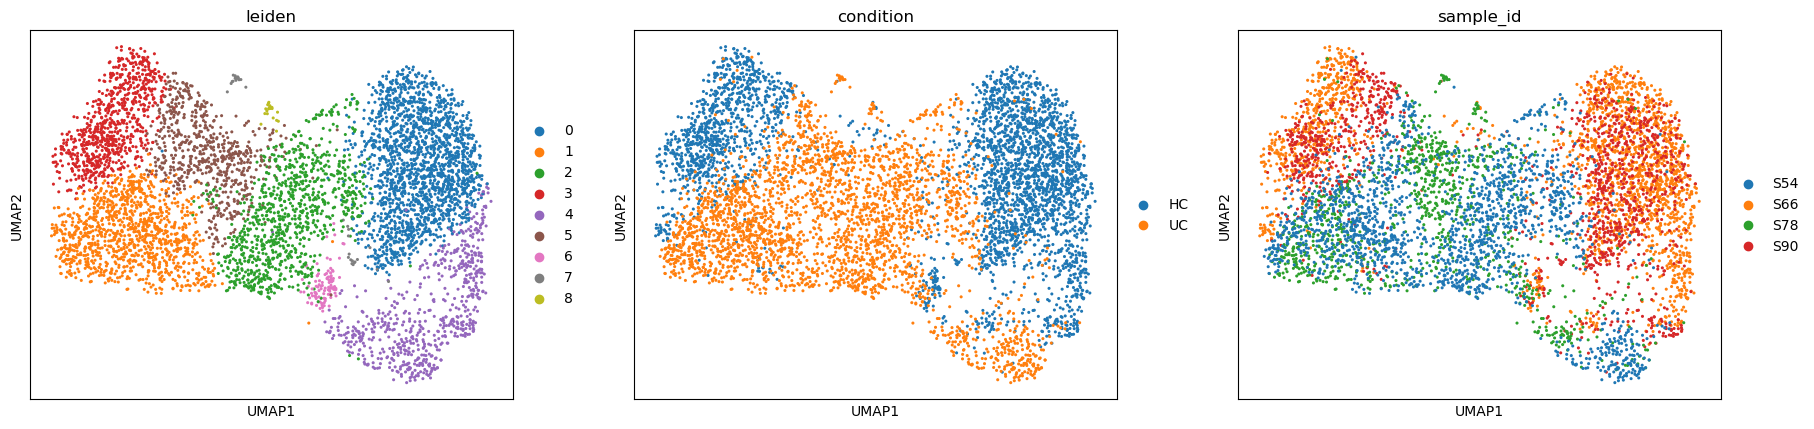

In [94]:
sc.pl.umap(sadata_sc, color=['leiden', 'condition', batch_key])

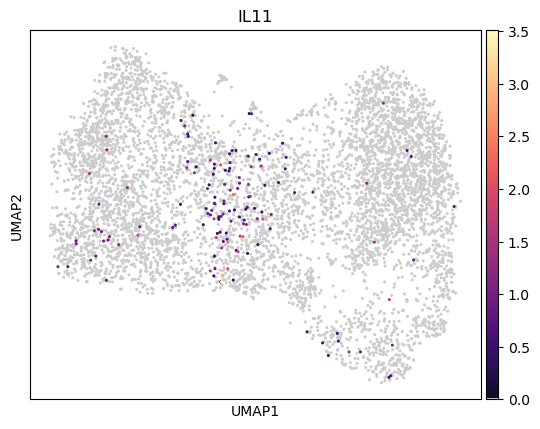

In [95]:
sc.pl.umap(sadata_sc, color=['IL11'], cmap=custom_cmap1)

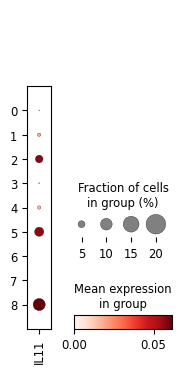

In [96]:
sc.pl.dotplot(sadata_sc, 'IL11', 'leiden')

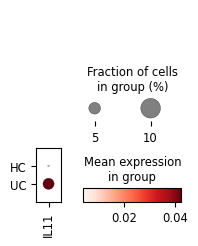

In [97]:
sc.pl.dotplot(sadata_sc, 'IL11', 'condition')